# **Most Used Words In The Harry Potter Movies**
---

## Introduction

The main objetive of this project is to answer a set of questions about the words used in the script of all the Harry Potter movies. The data that I'll be using is a clean dataset provided by Maven Analytics.

### My questions:

- What are the most used words by the golden trio in the movies?
- What are the most used/mentioned words in the potion's classroom?
- What are the most used/mentioned words in the slytherin common room by  Draco Malfoy?

---
## **Loading**

### Importing python libraries that I'll be using to analyze the data.

The libraries are:

- **Pandas**, for handling the data.
- **NLTK** (Natural Language ToolKit), for the mayority of the proccesing needed for Natural Language Processing.
- **Punctuations** from the **String** library, to help the removal of punctuations when needed.
- **Contractions**, to expand contracted words in the data, like "don't" to "do not".
- **Matplotlib** and **Seaborn**, for plotting the data.
- **Wordcloud**, to make a wordcloud visualization using words and their frequency.

In [1]:
import pandas as pd
import nltk
import string
import contractions

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

%matplotlib inline

### **Load the datasets**

The dataset used in this project is part of the "Harry Potter Movie Scripts" located in the Data Playground of Maven Analytics. 

I'll be using the "Characters.csv" and "Place.csv" as indexes, and the "Dialogue.csv" will be the main table used to answer my questions.

In [2]:
characters = pd.read_csv(r"hp_data/Characters.csv", encoding='latin-1')
characters.head()

,Character ID,Character Name,Species,Gender,House,Patronus,Wand (Wood),Wand (Core)
0,1,Harry Potter,Human,Male,Gryffindor,Stag,Holly,Phoenix Feather
1,2,Ron Weasley,Human,Male,Gryffindor,Jack Russell Terrier,NaN,NaN
2,3,Hermione Granger,Human,Female,Gryffindor,Otter,Vine,Dragon Heartstring
3,4,Albus Dumbledore,Human,Male,Gryffindor,Phoenix,Elder,Thestral Tail Hair
4,5,Rubeus Hagrid,Half-Human/Half-Giant,Male,Gryffindor,NaN,Oak,NaN


In [3]:
places = pd.read_csv(r"hp_data/Places.csv", encoding='latin-1')
places.head()

,Place ID,Place Name,Place Category
0,1,Flourish & Blotts,Diagon Alley
1,2,Gringotts Wizarding Bank,Diagon Alley
2,3,Knockturn Alley,Diagon Alley
3,4,Ollivanders,Diagon Alley
4,5,The Leaky Cauldron,Diagon Alley


In [4]:
dialogue = pd.read_csv(r"hp_data/Dialogue.csv", encoding='latin-1')
dialogue.head()

,Dialogue ID,Chapter ID,Place ID,Character ID,Dialogue
0,1,1,8,4,I should have known that you would be here...P...
1,2,1,8,7,"Good evening, Professor Dumbledore. Are the ru..."
2,3,1,8,4,"I'm afraid so, Professor. The good, and the bad."
3,4,1,8,7,And the boy?
4,5,1,8,4,Hagrid is bringing him.


### **Exploring the data**

#### Checking columns names and basic info.

In [5]:
print(characters.columns)
characters.info()

Index(['Character ID', 'Character Name', 'Species', 'Gender', 'House',
       'Patronus', 'Wand (Wood)', 'Wand (Core)'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Character ID    166 non-null    int64 
 1   Character Name  166 non-null    object
 2   Species         125 non-null    object
 3   Gender          125 non-null    object
 4   House           75 non-null     object
 5   Patronus        20 non-null     object
 6   Wand (Wood)     21 non-null     object
 7   Wand (Core)     18 non-null     object
dtypes: int64(1), object(7)
memory usage: 10.5+ KB


In [6]:
print(dialogue.columns)
dialogue.info()

Index(['Dialogue ID', 'Chapter ID', 'Place ID', 'Character ID', 'Dialogue'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7444 entries, 0 to 7443
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Dialogue ID   7444 non-null   int64 
 1   Chapter ID    7444 non-null   int64 
 2   Place ID      7444 non-null   int64 
 3   Character ID  7444 non-null   int64 
 4   Dialogue      7444 non-null   object
dtypes: int64(4), object(1)
memory usage: 290.9+ KB


#### Changing columns names to allow an easier access

In [7]:
characters.columns = (characters
    .columns
    .str.replace(' ','_')
    .str.lower())
characters.columns

Index(['character_id', 'character_name', 'species', 'gender', 'house',
       'patronus', 'wand_(wood)', 'wand_(core)'],
      dtype='object')

In [8]:
places.columns = (places
    .columns
    .str.replace(' ','_')
    .str.lower())
places.columns

Index(['place_id', 'place_name', 'place_category'], dtype='object')

In [9]:
dialogue.columns = (dialogue
    .columns
    .str.replace(' ','_')
    .str.lower())
dialogue.columns

Index(['dialogue_id', 'chapter_id', 'place_id', 'character_id', 'dialogue'], dtype='object')

---
### Pre-procesing the data for NLP

Even if this won't be used (at least not in this notebook) for a natural language processing model, I found it useful to go through some of the text preprocessing steps because it allows me to practice some of the workflow of this branch of Natural Language Science. Computing. data. and it gives me processed data that makes it easy for me to get the frequencies of the words in the dataset while removing punctuation and non-value words from the questions I want to answer and .

#### Steps:
1. Expand contractions like "don't" to "do not".
2. Convert the column without contractions to string.
3. Divide each word into a token.
4. Lowercase all words.
5. Remove punctuations.
6. Lemmatization:
   1. Identify parts of speech using NLTK tag.
   2. Remove stopwords.
   3. Convert to wordnet format for the sake of the NLTK's word lemmatizer.
   4. Apply the lemmatizer.

In [10]:
# Expanding contractions

dialogue["no_contract"] = dialogue['dialogue'].apply(lambda x:
    [contractions.fix(word) for word in x.split()])

# converting the columns without contractions to string

dialogue['dialogue_str'] = [' '.join(map(str, l)) for l in 
    dialogue['no_contract']]

# Tokenize the dialogue word by word

dialogue['tokenized'] = dialogue['dialogue_str'].apply(word_tokenize)

# Convert the tokens to lowercase

dialogue['lower'] = dialogue['tokenized'].apply(lambda x: 
    [word.lower() for word in x])

# Remove punctuations like ?,!

punc = string.punctuation

dialogue['no_punc'] = dialogue['lower'].apply(lambda x: [word for word in x if 
    word not in punc])

# Use NLTK pos_tag to identify parts of speech

dialogue['pos_tag'] = dialogue['no_punc'].apply(nltk.tag.pos_tag)


# Remove irrelevant words and other type of punctuations or part of contractions 
# that were left in our data

others_stopwords = ["...",'--','i-i',"'s", 'would','could', 'u'] 
stop_words = set(stopwords.words('english'))
stop_words.update(others_stopwords)
dialogue['stopwords_removed'] = dialogue['pos_tag'].apply(lambda x: [(word,tag) for (word,tag) in
    x if word not in stop_words])

# Transform the data to wordnet while simplifying the parts of speechs

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

dialogue['wordnet_pos'] = dialogue['stopwords_removed'].apply(lambda x: [(word,
    get_wordnet_pos(pos_tag)) for (word,pos_tag) in x])

# Finaly apply the lemmatizer to the data

wnl = WordNetLemmatizer()
dialogue['lemmatized'] = dialogue['wordnet_pos'].apply(lambda x:
    [wnl.lemmatize(word, tag) for word, tag in x])


dialogue.head()

,dialogue_id,chapter_id,place_id,character_id,dialogue,no_contract,dialogue_str,tokenized,lower,no_punc,pos_tag,stopwords_removed,wordnet_pos,lemmatized
0,1,1,8,4,I should have known that you would be here...P...,"[I, should, have, known, that, you, would, be,...",I should have known that you would be here...P...,"[I, should, have, known, that, you, would, be,...","[i, should, have, known, that, you, would, be,...","[i, should, have, known, that, you, would, be,...","[(i, NN), (should, MD), (have, VB), (known, VB...","[(known, VBN), (professor, NN), (mcgonagall, NN)]","[(known, v), (professor, n), (mcgonagall, n)]","[know, professor, mcgonagall]"
1,2,1,8,7,"Good evening, Professor Dumbledore. Are the ru...","[Good, evening,, Professor, Dumbledore., Are, ...","Good evening, Professor Dumbledore. Are the ru...","[Good, evening, ,, Professor, Dumbledore, ., A...","[good, evening, ,, professor, dumbledore, ., a...","[good, evening, professor, dumbledore, are, th...","[(good, JJ), (evening, NN), (professor, NN), (...","[(good, JJ), (evening, NN), (professor, NN), (...","[(good, a), (evening, n), (professor, n), (dum...","[good, evening, professor, dumbledore, rumour,..."
2,3,1,8,4,"I'm afraid so, Professor. The good, and the bad.","[I am, afraid, so,, Professor., The, good,, an...","I am afraid so, Professor. The good, and the bad.","[I, am, afraid, so, ,, Professor, ., The, good...","[i, am, afraid, so, ,, professor, ., the, good...","[i, am, afraid, so, professor, the, good, and,...","[(i, NN), (am, VBP), (afraid, VBN), (so, RB), ...","[(afraid, VBN), (professor, IN), (good, JJ), (...","[(afraid, v), (professor, n), (good, a), (bad,...","[afraid, professor, good, bad]"
3,4,1,8,7,And the boy?,"[And, the, boy?]",And the boy?,"[And, the, boy, ?]","[and, the, boy, ?]","[and, the, boy]","[(and, CC), (the, DT), (boy, NN)]","[(boy, NN)]","[(boy, n)]",[boy]
4,5,1,8,4,Hagrid is bringing him.,"[Hagrid, is, bringing, him.]",Hagrid is bringing him.,"[Hagrid, is, bringing, him, .]","[hagrid, is, bringing, him, .]","[hagrid, is, bringing, him]","[(hagrid, NN), (is, VBZ), (bringing, VBG), (hi...","[(hagrid, NN), (bringing, VBG)]","[(hagrid, n), (bringing, v)]","[hagrid, bring]"


---
## **Functions and queries**

#### Using the Characters and Place tables as dictionaries to be more readable.

In [11]:
def char(name):
    return int(characters[characters['character_name'] == name].character_id)

def place(name):
    return int(places[places['place_name'] == name].place_id)


#### Creating a function that returns a series with the frequencies of the words an also can query the data by character id and/or place id.

In [12]:
def most_used_words(ID=None, place_id=None,count=10):
    query = ''
    if place_id:
        query = 'place_id == @place_id'
        if ID and type(place_id) is int:
            print(type(ID))
            if type(ID) is list:
                query = 'character_id in @ID & place_id == @place_id'
            elif type(ID) is int:
                query = 'character_id == @ID & place_id == @place_id'
            else:
                raise Exception('Expected ID argument is not a list or an integerd')
    elif ID:
        if type(ID) is list:
            query = 'character_id in @ID'
        elif type(ID) is int:
            query = 'character_id == @ID'
        else:
            raise Exception('Expected ID argument is not a list or an integer')
    
    if query == '':
        words_lemmatized = dialogue.lemmatized
    else:
        words_lemmatized = dialogue.query(query).lemmatized
    
    #sw = ["u","...",'--','i-i',"","'s"]
    charwords = [word for wordlist in words_lemmatized for word in wordlist]
    #           [leaf for branch   in tree             for leaf in branch]
    return pd.Series(dict(FreqDist(charwords).most_common(count)))

Word cloud image from a series

In [13]:
def wordcloud_image(data):
    image = WordCloud(font_path=r'fonts\HARRYP__.TTF',width=800, height=500, colormap="winter",
                      background_color='white').generate_from_frequencies(data)
    return image

def show_image(image,title='Title',fontsize=24):
    fig = plt.figure(figsize=(20,5), facecolor='white')
    plt.imshow(image, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize= fontsize)
    plt.show()

---
## **Visualizations**

### Most Used Words In The Harry Potter Movies

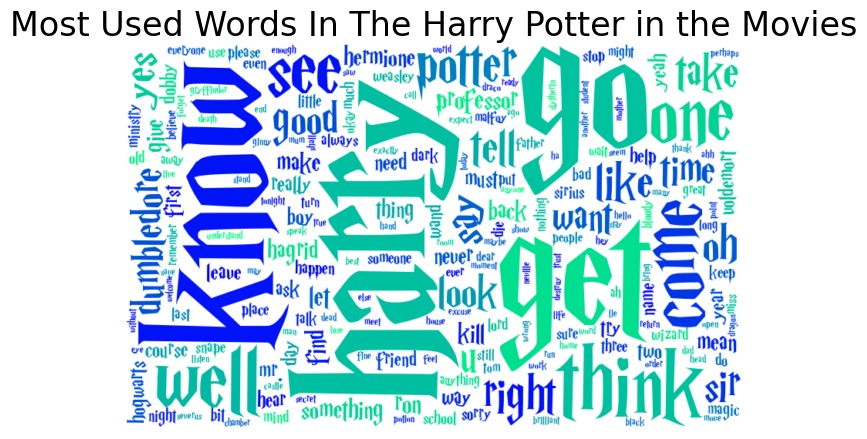

In [14]:
mostcommon = most_used_words(count=200)
wordcloud = wordcloud_image(mostcommon)
show_image(image=wordcloud, title='Most Used Words In The Harry Potter in the Movies', fontsize= 24)


[Text(0.5, 1.0, 'TOP 10: Most used words')]

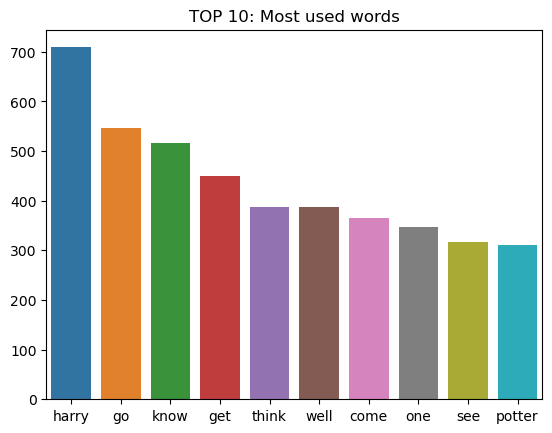

In [15]:
top_10 = most_used_words(count=10)
sns.barplot( x=top_10.index, y=top_10.values).set(title='TOP 10: Most used words')

### Most used words by the Golden Trio

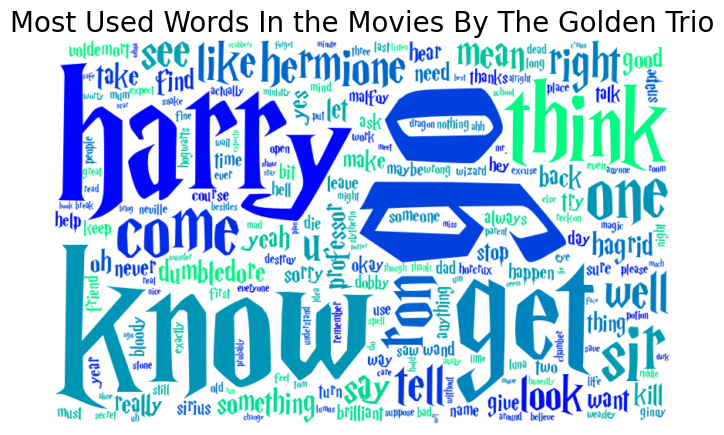

In [16]:
golden_trio = ['Harry Potter','Hermione Granger', 'Ron Weasley']
ids = [char(name) for name in golden_trio]

mostcommon = most_used_words( ID=ids, count=200)
wordcloud = wordcloud_image(mostcommon)
show_image(image=wordcloud, title='Most Used Words In the Movies By The Golden Trio', fontsize= 20)

[Text(0.5, 1.0, 'TOP 10: Most used words by the Golden Trio')]

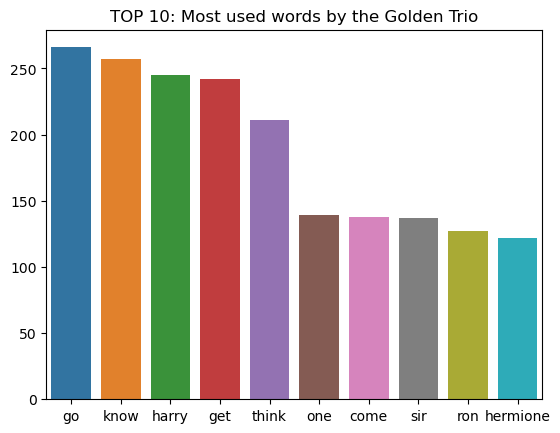

In [17]:
top_10 = most_used_words(ID=ids, count=10)
sns.barplot( x=top_10.index, y=top_10.values).set(title='TOP 10: Most used words by the Golden Trio')

### Most Used words in the Potions Classroom

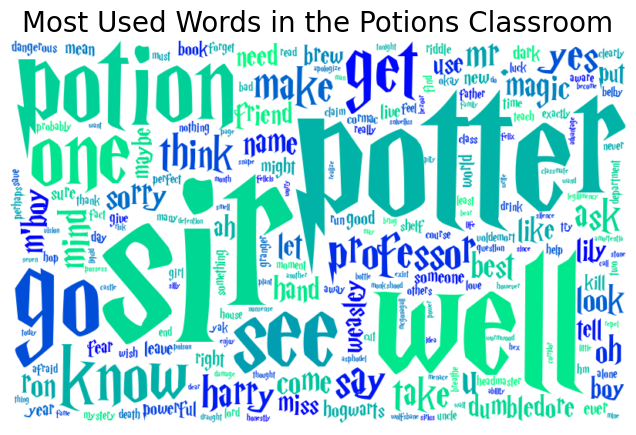

In [18]:
mostcommon = most_used_words(place_id=place('Potions Classroom'), count=200)
wordcloud = wordcloud_image(mostcommon)
show_image(image=wordcloud, title='Most Used Words in the Potions Classroom', fontsize= 20)

[Text(0.5, 1.0, 'TOP 10: Most used words, Potions Classroom')]

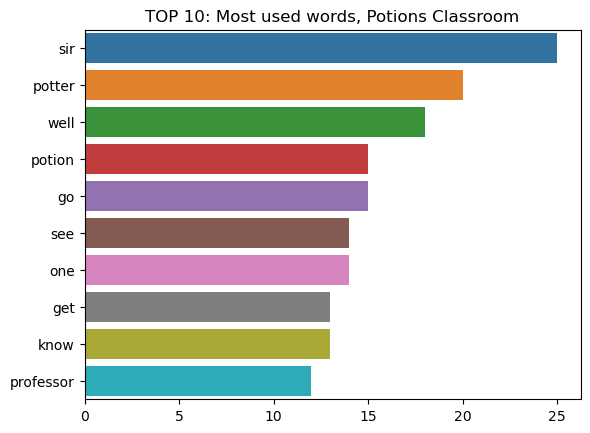

In [19]:
top_10 = most_used_words(place_id=place('Potions Classroom'), count=10)
sns.barplot( x=top_10.values, y=top_10.index).set(title='TOP 10: Most used words, Potions Classroom')

### Most Used words in the Great Hall by Draco Malfoy

<class 'int'>


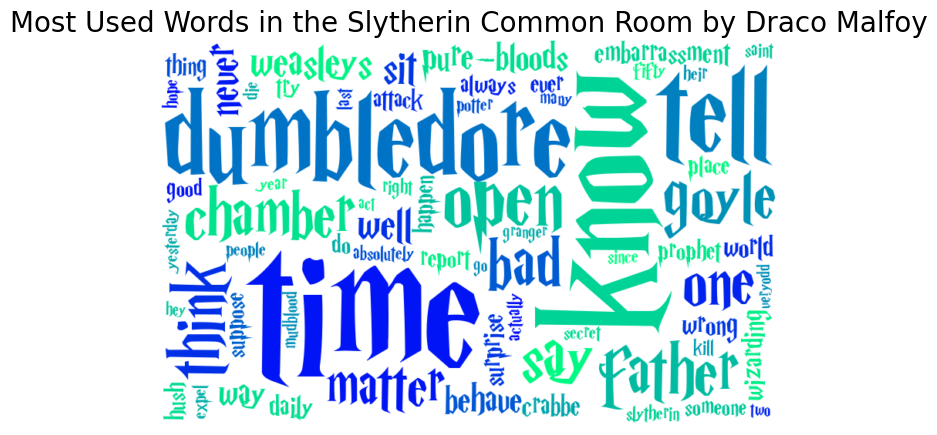

In [20]:
mostcommon = most_used_words( ID=char('Draco Malfoy'), place_id=place('Slytherin Common Room'), count=200)
wordcloud = wordcloud_image(mostcommon)
show_image(image=wordcloud, title='Most Used Words in the Slytherin Common Room by Draco Malfoy', fontsize= 20)

<class 'int'>


[Text(0.5, 1.0, 'TOP 10: Most used words, Slytherin Common Room by Draco Malfoy')]

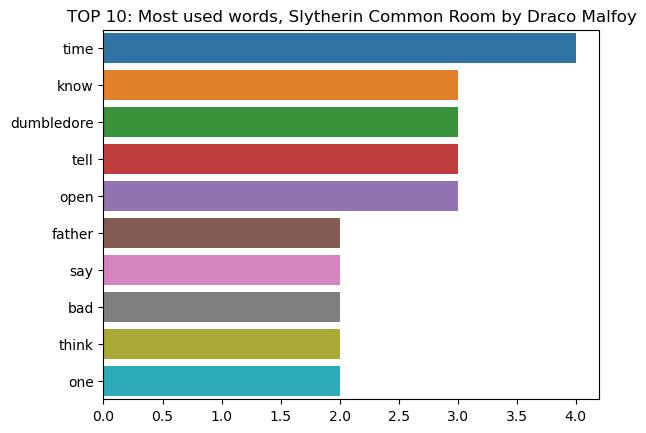

In [21]:
top_10 = most_used_words(ID=char('Draco Malfoy'), place_id=place('Slytherin Common Room'), count=10)
sns.barplot( x=top_10.values, y=top_10.index).set(title='TOP 10: Most used words, Slytherin Common Room by Draco Malfoy')